In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow --quiet

In [3]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [4]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

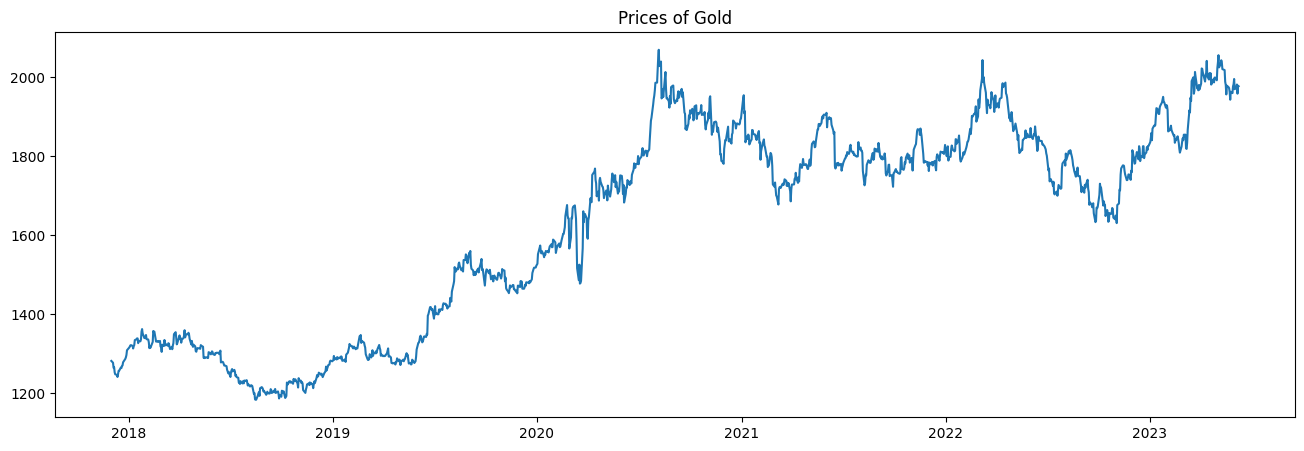

In [5]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [6]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [8]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [9]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [10]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.08701, saving model to save_model(7-2-1).hdf5
20/20 - 2s - loss: 0.0870 - 2s/epoch - 79ms/step
Epoch 2/80

Epoch 2: loss improved from 0.08701 to 0.02656, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0266 - 85ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.02656 to 0.02098, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0210 - 77ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02098 to 0.01737, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0174 - 79ms/epoch - 4ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01737 to 0.01641, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0164 - 80ms/epoch - 4ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.01641
20/20 - 0s - loss: 0.0174 - 66ms/epoch - 3ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01641 to 0.01575, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0158 - 86ms/epoch - 4ms/step
Epoch 

In [187]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 [==============================] - 0s 2ms/step


In [188]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 3ms/step


In [189]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 3ms/step


In [190]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input.shape)
        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
[[0.8987928628921509], [0.9037451148033142], [0.9033491015434265], [0.9063144326210022], [0.9083166122436523], [0.910305917263031], [0.9127904176712036], [0.9148051142692566], [0.9169437289237976], [0.9190176129341125], [0.9210164546966553], [0.9230387210845947], [0.9250085949897766], [0.9269565343856812], [0.9288774728775024], [0.9307630658149719], [0.9326226115226746], [0.9344518780708313], [0.9362525939941406], [0.9380254745483398], [0.9397693276405334], [0.9414854049682617], [0.9431735277175903], [0.9448336958885193], [0.9464666247367859], [0.948072612285614], [0.9496514797210693], [0.9512038826942444], [0.9527297616004944], [0.9542298913002014]]


In [191]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

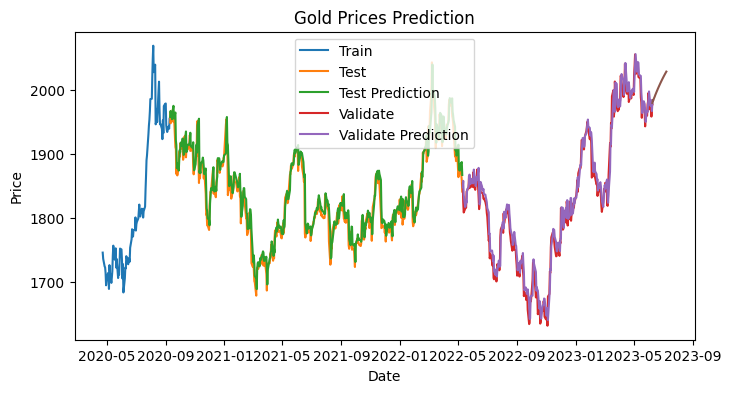

In [192]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(8, 4))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [193]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [194]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.672236601289335
MAPE:  0.7457428213100454
RMSE:  19.215736884698245

** Validate **
MAE:  13.751386821186625
MAPE:  0.7544885491343267
RMSE:  17.986463666608188


# Split dataset (6-3-1)

---



In [195]:
# Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [196]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [197]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [198]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(6-3-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.11380, saving model to save_model(6-3-1).hdf5
18/18 - 1s - loss: 0.1138 - 1s/epoch - 64ms/step
Epoch 2/80

Epoch 2: loss improved from 0.11380 to 0.03646, saving model to save_model(6-3-1).hdf5
18/18 - 0s - loss: 0.0365 - 71ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.03646 to 0.02867, saving model to save_model(6-3-1).hdf5
18/18 - 0s - loss: 0.0287 - 66ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02867 to 0.02240, saving model to save_model(6-3-1).hdf5
18/18 - 0s - loss: 0.0224 - 77ms/epoch - 4ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02240 to 0.01960, saving model to save_model(6-3-1).hdf5
18/18 - 0s - loss: 0.0196 - 75ms/epoch - 4ms/step
Epoch 6/80

Epoch 6: loss improved from 0.01960 to 0.01887, saving model to save_model(6-3-1).hdf5
18/18 - 0s - loss: 0.0189 - 70ms/epoch - 4ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01887 to 0.01783, saving model to save_model(6-3-1).hdf5
18/18 - 0s -

In [199]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(6-3-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

27/27 [==============================] - 0s 2ms/step


In [200]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 2ms/step


In [201]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [202]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.9146109819412231], [0.9309272766113281], [0.9446799159049988], [0.9598999619483948], [0.9728338122367859], [0.9860250353813171], [0.9988561868667603], [1.0112429857254028], [1.0234061479568481], [1.0350958108901978], [1.0463955402374268], [1.0572741031646729], [1.0677179098129272], [1.0777411460876465], [1.0873314142227173], [1.0964943170547485], [1.105231761932373], [1.113547444343567], [1.1214486360549927], [1.1289433240890503], [1.1360409259796143], [1.142751932144165], [1.1490882635116577], [1.155062198638916], [1.1606870889663696], [1.1659761667251587], [1.1709439754486084], [1.1756043434143066], [1.17997145652771], [1.1840598583221436]]


<Figure size 1600x500 with 0 Axes>

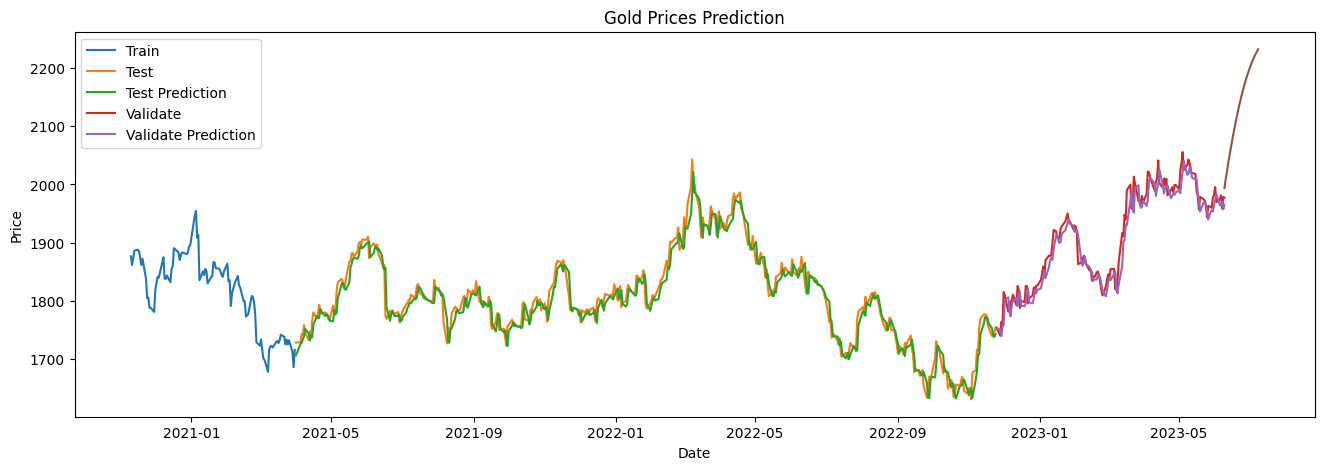

In [203]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [204]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  12.900243343895688
MAPE:  0.7131392342136109
RMSE:  17.39229008270384

** Validate **
MAE:  15.74582024420892
MAPE:  0.8200957649767828
RMSE:  20.16596717842755


# Split dataset (5-3-2)

---



In [205]:
# Split data (5-3-2)
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [206]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [207]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [208]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(5-3-2).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.14901, saving model to save_model(5-3-2).hdf5
15/15 - 2s - loss: 0.1490 - 2s/epoch - 125ms/step
Epoch 2/80

Epoch 2: loss improved from 0.14901 to 0.04205, saving model to save_model(5-3-2).hdf5
15/15 - 0s - loss: 0.0420 - 73ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: loss improved from 0.04205 to 0.02221, saving model to save_model(5-3-2).hdf5
15/15 - 0s - loss: 0.0222 - 70ms/epoch - 5ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02221 to 0.01931, saving model to save_model(5-3-2).hdf5
15/15 - 0s - loss: 0.0193 - 77ms/epoch - 5ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01931 to 0.01865, saving model to save_model(5-3-2).hdf5
15/15 - 0s - loss: 0.0186 - 71ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss improved from 0.01865 to 0.01691, saving model to save_model(5-3-2).hdf5
15/15 - 0s - loss: 0.0169 - 85ms/epoch - 6ms/step
Epoch 7/80

Epoch 7: loss improved from 0.01691 to 0.01611, saving model to save_model(5-3-2).hdf5
15/15 - 0s 

In [209]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(5-3-2).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 [==============================] - 0s 2ms/step


In [210]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 2ms/step


In [211]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [212]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.9131668210029602], [0.9282554388046265], [0.9407769441604614], [0.954720139503479], [0.9669426083564758], [0.9796126484870911], [0.9922438263893127], [1.0047154426574707], [1.0171796083450317], [1.029448390007019], [1.0415785312652588], [1.0535506010055542], [1.0653505325317383], [1.076979160308838], [1.088419795036316], [1.0996650457382202], [1.1107054948806763], [1.1215322017669678], [1.1321383714675903], [1.14251708984375], [1.1526620388031006], [1.1625676155090332], [1.172229290008545], [1.1816428899765015], [1.1908050775527954], [1.1997132301330566], [1.208365559577942], [1.2167611122131348], [1.224899411201477], [1.2327800989151]]


<Figure size 1600x500 with 0 Axes>

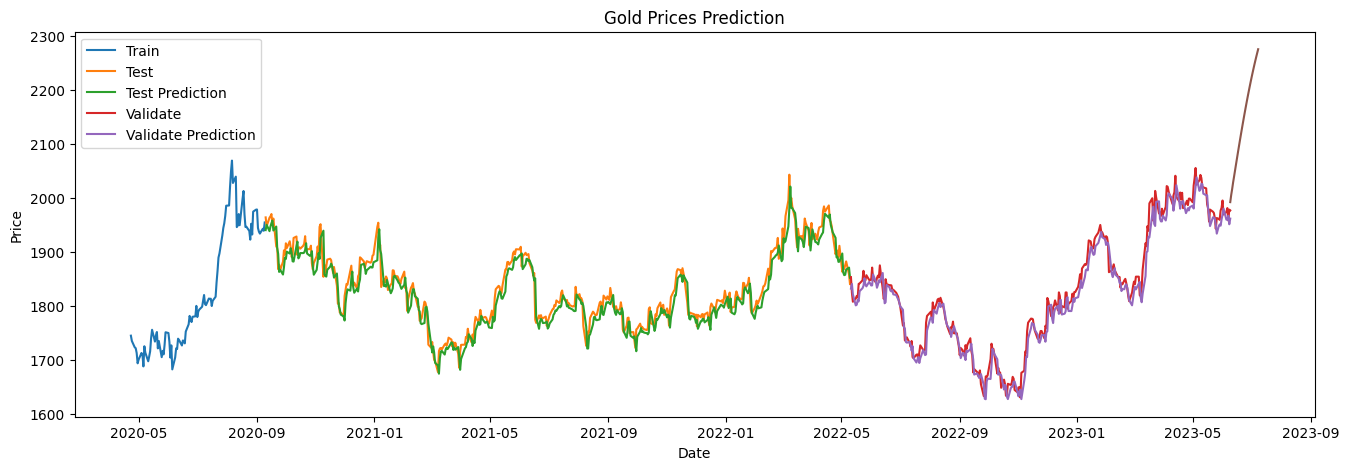

In [213]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [214]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  16.046435262328824
MAPE:  0.8704131925838025
RMSE:  20.406291044531745

** Validate **
MAE:  15.533347731370197
MAPE:  0.842528785601393
RMSE:  20.033570379148436


# Evaluating model

---

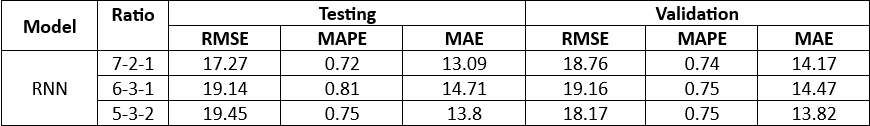